
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 1 <br>
<font color=696880 size=4>
    Niloufar Abbasi

____

# Emotion Recognition with Recurrent Neural Networks


---

## **Introduction**

In this task, you will implement a Recurrent Neural Network (RNN) to perform tweet emotion recognition. The goal is to classify tweets into one of six basic emotions:
- **0: sadness**
- **1: joy**
- **2: love**
- **3: anger**
- **4: fear**
- **5: surprise**

We will be using a dataset of tweets, where each tweet has been labeled with one of these emotions. Throughout this notebook, you will follow step-by-step instructions to build and train your model. As you progress, you'll complete the provided TODO sections by filling in the necessary code and functions.

By the end of this exercise, you will:
- Understand how to preprocess text data for use in RNN models.
- Build and train a model using Pytorch.
- Evaluate the performance of your model on the test set.

---


---

## Task 1: Enter Your Information

Before we begin, please enter your **student ID** and **name** in the code section below.

Make sure to replace the placeholders with your actual information.

---

In [1]:
#########################################
# TODO: Enter your personal information #
#########################################

student_name = "Adel Movahedian"  # Replace with your name
student_id   = 400102074  # Replace with your student ID

print("Your name:", student_name)
print("Your student ID:", student_id)

Your name: Adel Movahedian
Your student ID: 400102074


---

## Task 2: Setup and Imports

In this task, we'll be preparing our environment by importing the necessary libraries. Please run the cells below to set everything up. If any library is missing on your end, make sure to install it.

### Instructions:
1. **Run the cells** to install any required packages and import the necessary libraries.
2. If any library is not installed in your environment, use `!pip install <library_name>` to install it.
---

In [2]:
!pip install datasets

Required Libraries:

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import load_dataset

%matplotlib inline

#####################################################################
# TODO: Add any additional libraries you may need for your analysis #
#####################################################################

# You can add your libraries here
from transformers import AutoTokenizer
import re
from collections import Counter
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import cross_entropy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Additional Functions

The following functions have been provided to help you visualize the results of your model training. These will allow you to analyze both the model's performance over time (through the training history) and how well it performs on individual predictions (through a confusion matrix).

1. **`plot_history(hist)`**: This function takes the training history object (`hist`) from your model and plots both the accuracy and loss over the number of epochs for both training and validation sets. It provides an easy way to visually track the model's learning progress and performance.

2. **`visualize_confusion_matrix(actual_labels, predicted_labels, classes)`**: After making predictions with your model, you can use this function to plot a confusion matrix. It shows the accuracy of your model across each class, helping to identify areas where the model is performing well and where it might be struggling. The matrix is normalized to make comparisons easier.

These functions are for your convenience, you can directly use them after running your model to visualize the results.


In [4]:
# Functions to visualize training history and confusion matrix
def plot_history(hist):
    epochs = len(hist.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs), hist.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs), hist.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs), hist.history.get('loss'), label='Training')
    plt.plot(range(0, epochs), hist.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize_confusion_matrix(actual_labels, predicted_labels, classes):

    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


---

## Task 3: Importing Data

In this task, we will

- import the Tweet Emotion dataset

- create training, validation, and test sets
    
- extract the tweets and their corresponding labels for further analysis

---

In [5]:
dataset = load_dataset('emotion')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
# Display the first few samples
print(dataset['train'][0:5])  # Adjust 'train' to 'test' or other splits if necessary

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [7]:
###########################################################################
# TODO: Create variables for the training, validation, and test datasets. #
###########################################################################

training = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [8]:
########################################################################################################
# TODO:                                                                                                #
# Implement the `extract_tweets_labels` function to iterate over the provided dataset.                 #
# Within this function, extract the tweet text and their corresponding labels into two separate lists. #
# Then, call this function with the training dataset to obtain the tweets and labels,                  #
# ensuring proper data handling for subsequent analysis.                                               #
########################################################################################################

def extract_tweets_labels(data):
    # Extract the text and labels from the data
    tweets = [item['text'] for item in data]
    labels = [item['label'] for item in data]
    return tweets, labels

# Get the tweets and labels from the training set
tweets, labels = extract_tweets_labels(training)

# Display the first tweet and its label
print(tweets[0], labels[0])


i didnt feel humiliated 0


---

## Task 4: Tokenization of Tweets

In this section, we will focus on the tokenization of the tweets in the dataset. Tokenization is a crucial step in natural language processing (NLP) that involves breaking down text into smaller units, such as words or subwords. This process enables the model to better understand and analyze the text data.

### Objectives:
1. Implement a tokenizer to convert the tweet texts into tokens.
2. Ensure the tokenization process handles various aspects of the text, such as punctuation and special characters.

By the end of this task, you will have a set of tokenized tweets ready for further processing in your NLP pipeline.

---

In [9]:
###############################################################################################################################################
# TODO: Tokenization of Tweets                                                                                                                #
# 1. Select a Tokenization Method: Choose a suitable tokenization method to preprocess the tweets.                                            #
# Ensure that the tokenization handles special characters and maintains the integrity of the text data.                                       #
# 2. Implement the Tokenizer: Once you have selected a method, implement the tokenizer to convert the tweet texts into sequences of tokens.   #
# 3. Test the Tokenization:                                                                                                                   #
# Verify the functionality of your tokenizer by applying it to a sample tweet from the dataset and displaying the resulting tokenized output. #
###############################################################################################################################################

def my_tokenizer(text):
    text = text.lower() # lowercase to not be case sensitive
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # keep needed parts (handles special characters)
    tokens = text.split() # Split with whitespace
    return tokens
tokenized_tweets = [my_tokenizer(tweet) for tweet in tweets]

sample_tweet = tweets[0]
sample_tokenized = my_tokenizer(sample_tweet)

print("Original Tweet:", sample_tweet)
print("Tokenized Tweet:", sample_tokenized)

# we need to create vocabulary for the continue of the code
unique_tokens = set(token for tweet in tokenized_tweets for token in tweet)
token_to_idx = {token: idx for idx, token in enumerate(unique_tokens, start=1)}  # Start indexing from 1, I kept zero for pad
token_to_idx["<PAD>"] = 0  # Add padding token with index 0 set manualy
# Map tokens to indices
def tokens_to_indices(tokens, token_to_idx):
    return [token_to_idx[token] for token in tokens if token in token_to_idx]


Original Tweet: i didnt feel humiliated
Tokenized Tweet: ['i', 'didnt', 'feel', 'humiliated']


---

## Task 5: Padding and Truncating Sequences

In this task, we will prepare the tokenized tweets for model training by checking their lengths and creating padded sequences.

1. **Checking the Length of the Tweets**
   - Analyze the distribution of tweet lengths to understand the range of token counts in the dataset.

2. **Creating Padded Sequences**
   - After tokenizing the tweets, sequences of different lengths must be adjusted to a uniform length to facilitate training.

---


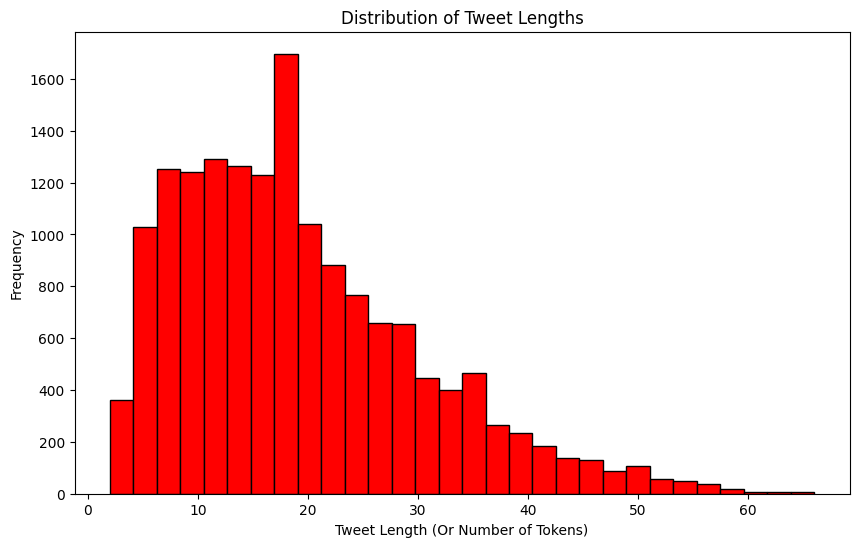

Selected Maximum Length for Padding and Truncating is 66


In [10]:
#####################################################################################################################################################
# TODO:                                                                                                                                             #
# Implement code to calculate the lengths of the tweets and visualize the distribution using a histogram. Use an appropriate visualization library. #
# After visualizing the distribution, determine a suitable maximum length for padding and truncating the sequences based on your findings.          #
#####################################################################################################################################################
tweet_lengths = [len(tweet) for tweet in tokenized_tweets]
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=30, color='red', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (Or Number of Tokens)')
plt.ylabel('Frequency')
plt.show()
max_length = max(tweet_lengths)
print(f"Selected Maximum Length for Padding and Truncating is {max_length}")


In [11]:
############################################################################################################
# TODO: Define a function to convert the tokenized tweets into sequences and apply padding and truncation. #
# Use your determined maximum length for padding the sequences.                                            #
############################################################################################################
def PadAndTruncate_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        seq_indices = tokens_to_indices(seq, token_to_idx)
        if len(seq_indices) < max_length:
            padded_seq = seq_indices + [token_to_idx["<PAD>"]] * (max_length - len(seq_indices))
        else:
            padded_seq = seq_indices[:max_length]
        padded_sequences.append(padded_seq)
    return padded_sequences
def get_sequences(tokenizer, tweets):
    sequences = [tokenizer(tweet) for tweet in tweets]
    padded_sequences = PadAndTruncate_sequences(sequences, max_length)
    return padded_sequences
padded_train_sequences = get_sequences(my_tokenizer, tweets)
padded_train_sequences[0]

[11768,
 8423,
 9036,
 978,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

---

## Task 6: Analyzing Label Distribution

1. Checking the distribution of labels.
2. Addressing any class imbalance using appropriate techniques.

Note:

(**Providing a clear explanation of the chosen method to address the imbalance and how it will improve the model’s performance is critical.** Without handling class imbalance properly, the model could achieve a high accuracy by focusing on the majority class, but it may perform poorly on the minority class, which would result in misleading metrics and reduced generalization.

Hence, it is important to not only implement an appropriate solution but also **justify** why the selected approach is effective for the given task.)

---

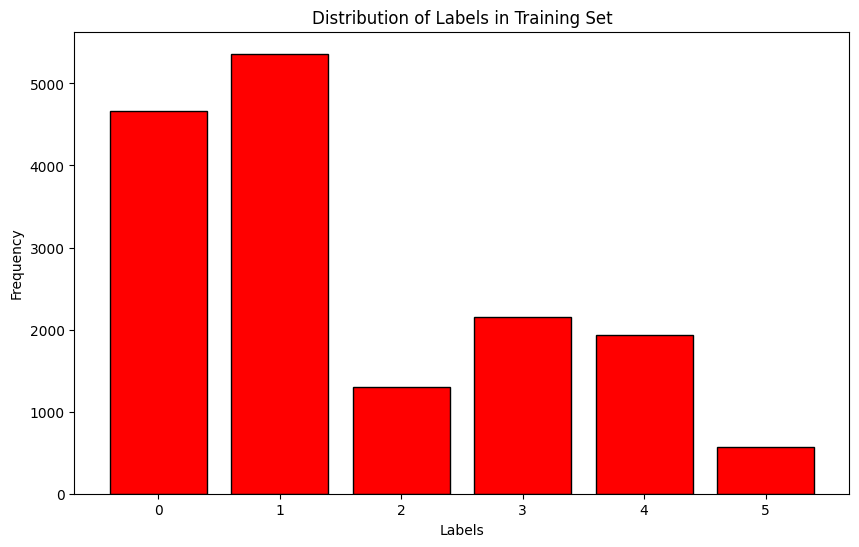

Label Distribution: Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
Balanced Label Distribution: Counter({0: 5362, 3: 5362, 2: 5362, 5: 5362, 4: 5362, 1: 5362})


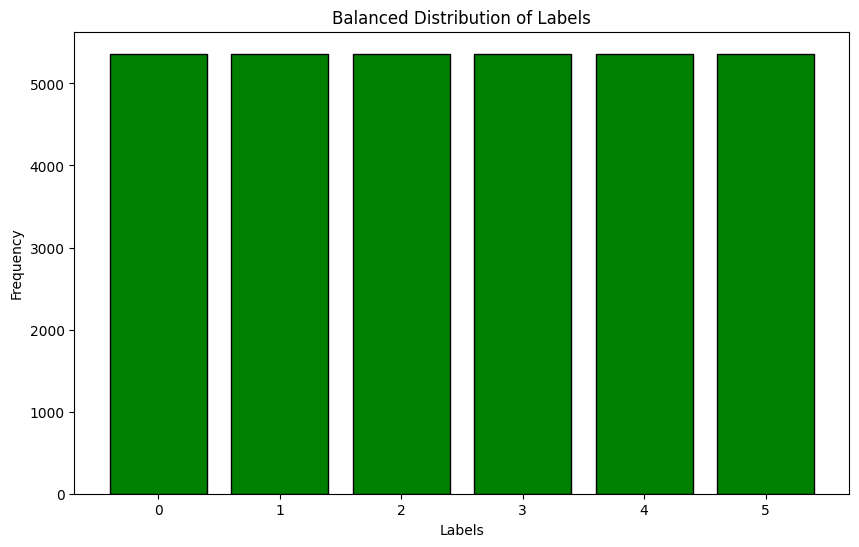

In [12]:
##########################################################################################################################
# TODO: Analyze the distribution of labels in the training set. (visualize it in a perfect way)                          #
# Determine if there is any class imbalance.                                                                             #
# If you observe any imbalance, apply one of the techniques you have learned throughout the course to address the issue. #
##########################################################################################################################
#Analyze Label Distribution using counter function from collections
label_counts = Counter(labels)
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='red', edgecolor='black')
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()
print("Label Distribution:", label_counts)

#oversampling to handle imbalance data -->after visualizing the previous part(data was imbalanced)
def oversample_minor_classes(tweets, labels):
    max_count = max(label_counts.values())
    balanced_tweets = []
    balanced_labels = []
    label_to_tweets = {label: [] for label in label_counts}
    for tweet, label in zip(tweets, labels):
        label_to_tweets[label].append(tweet)
    for label, tweets in label_to_tweets.items():
        balanced_tweets.extend(tweets * (max_count // len(tweets)) + tweets[:max_count % len(tweets)])
        balanced_labels.extend([label] * max_count)
    return balanced_tweets, balanced_labels

balanced_tweets, balanced_labels = oversample_minor_classes(tweets, labels)
balanced_label_counts = Counter(balanced_labels)
print("Balanced Label Distribution:", balanced_label_counts)
plt.figure(figsize=(10, 6))
plt.bar(balanced_label_counts.keys(), balanced_label_counts.values(), color='green', edgecolor='black')
plt.title('Balanced Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()



## <font color='green'>explanation
We addressed the issue of class imbalance in our dataset by using oversampling. This method involves replicating samples from the minority classes until all classes have an equal number of examples. Oversampling ensures the model gets an equal chance to learn from all classes, preventing it from focusing too heavily on the majority class.
By balancing the dataset, we encourage the model to treat all classes fairly, improving its ability to generalize to unseen data. This helps avoid misleading metrics, where high accuracy might come at the cost of poor performance on minority classes. Although oversampling can sometimes lead to overfitting, we mitigate this risk with techniques like early stopping. Overall, this approach helps the model perform more effectively across all classes.</font>

---

## Task 7: Creating the Model

Design and implement a recurrent neural network for the task. You may utilize a sequential architecture like RNN or GRU to enhance the model's performance.

Build and compile your model using Pytorch.

**Once the model is created, summarize its structure to verify the design.**

---

In [13]:
#########################################################################################################
# TODO:                                                                                                 #
# Create a recurrent neural network model for the task.                                                 #
# (Suggestion: Implement a Bidirectional LSTM architecture to process the input sequences effectively.) #
# Once the model is created, summarize its structure to verify the design.                              #
#########################################################################################################
# Defining Bidirectional LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 (bidirectional)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  #output of the last time step is the lstm output
        output = self.fc(lstm_out)
        return output
vocab_size = len(token_to_idx)
embedding_dim = 128
hidden_dim = 64
output_dim = len(label_counts)
padding_idx = token_to_idx["<PAD>"] # Padding index = 0 that I set it before
model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx)


#model's summary is printed below
print(model)

BiLSTMModel(
  (embedding): Embedding(15213, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


---

## Task 8: Training the Model

In this task, you will prepare a validation set and train your model using the training data.

1. Prepare the validation set by extracting tweets and labels, and convert them into sequences using the tokenizer.
2. Train the model on the training data.
3. Ensure that you implement **Early Stopping** to prevent overfitting and enhance efficiency.

Make sure to monitor the validation accuracy during training and adjust the parameters as necessary.

---

In [14]:
###############################################################################################################
# TODO: Extract the tweets and labels from the validation set. Convert the tweets into sequences using the    #
#       tokenizer defined earlier. Prepare the data for validation and ensure it matches the format of the    #
#       training set.                                                                                         #
###############################################################################################################

# Your code for extracting and processing validation data goes here
# Prepare validation data
val_tweets, val_labels = extract_tweets_labels(validation)
val_label_tensor = torch.tensor(val_labels, dtype=torch.long)

padded_train_sequences = get_sequences(my_tokenizer, balanced_tweets)
padded_val_sequences = get_sequences(my_tokenizer, val_tweets)

padded_train_tensor = torch.tensor(padded_train_sequences, dtype=torch.long)
train_label_tensor = torch.tensor(balanced_labels, dtype=torch.long)
padded_val_tensor = torch.tensor(padded_val_sequences, dtype=torch.long)
val_label_tensor = torch.tensor(val_labels, dtype=torch.long)

#DataLoaders
batch_size = 32
train_data = TensorDataset(padded_train_tensor, train_label_tensor)
val_data = TensorDataset(padded_val_tensor, val_label_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

###############################################################################################################
# TODO: Train the model on the prepared training data. Ensure you implement early stopping to monitor the     #
#       validation accuracy and prevent overfitting. Adjust the number of epochs or other hyperparameters as  #
#       needed to optimize model performance.                                                                 #
###############################################################################################################

# Your code for training the model with early stopping goes here
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

num_epochs = 20
patience_time = 3
best_val_loss = float('inf')
epochs_without_improvement = 0
history = {'train_loss': [],'train_accuracy': [],'val_loss': [],'val_accuracy': []}
# training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accuracy = correct / total

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = correct / total

    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    # if early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience_time:
            print("Early stopping activated.")
            break


Epoch 1/20 - Train Loss: 1803.1152, Train Acc: 0.1644, Val Loss: 113.5781, Val Acc: 0.1375
Epoch 2/20 - Train Loss: 1801.5353, Train Acc: 0.1678, Val Loss: 112.7339, Val Acc: 0.0435
Epoch 3/20 - Train Loss: 1798.9668, Train Acc: 0.1692, Val Loss: 112.6249, Val Acc: 0.3485
Epoch 4/20 - Train Loss: 1761.2576, Train Acc: 0.2049, Val Loss: 105.5357, Val Acc: 0.2295
Epoch 5/20 - Train Loss: 1079.6806, Train Acc: 0.5569, Val Loss: 66.7999, Val Acc: 0.5250
Epoch 6/20 - Train Loss: 504.3599, Train Acc: 0.8260, Val Loss: 44.1508, Val Acc: 0.7740
Epoch 7/20 - Train Loss: 259.8186, Train Acc: 0.9234, Val Loss: 36.4621, Val Acc: 0.8390
Epoch 8/20 - Train Loss: 156.8525, Train Acc: 0.9577, Val Loss: 37.8023, Val Acc: 0.8385
Epoch 9/20 - Train Loss: 110.0162, Train Acc: 0.9729, Val Loss: 37.5024, Val Acc: 0.8460
Epoch 10/20 - Train Loss: 93.0233, Train Acc: 0.9767, Val Loss: 35.1352, Val Acc: 0.8575
Epoch 11/20 - Train Loss: 78.3364, Train Acc: 0.9803, Val Loss: 36.5652, Val Acc: 0.8600
Epoch 12/20 

---

## Task 9: Evaluating the Model

In this task, you will evaluate the performance of your model on the test set and visualize the training history. You will also analyze the model’s predictions on both individual and complete test samples.

### Steps:
1. Visualize the loss and accuracy over the training epochs.
2. Prepare and preprocess the test data using functions from Task 2.
3. Evaluate the model on the test set and examine individual predictions.
4. Analyze the overall predictions and display a confusion matrix.

---

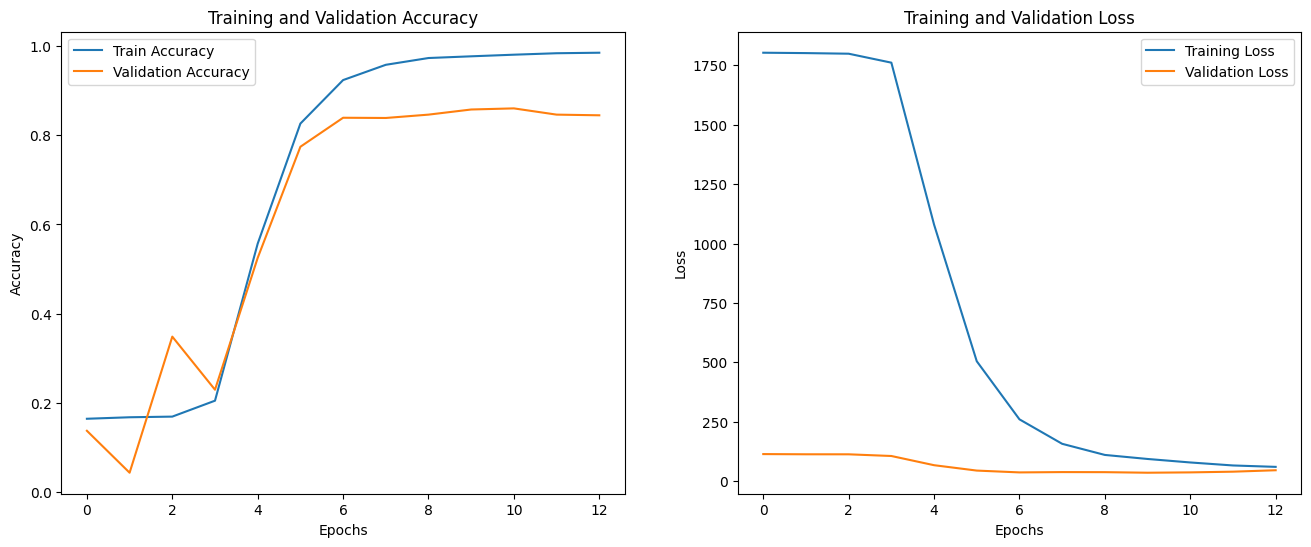

In [15]:
###############################################################################################################
# TODO: Visualize the training history by plotting the loss and accuracy over the epochs to assess model      #
#       performance. Use an appropriate visualization method to ensure clarity and effectiveness.             #
#       you can use function implemented in Task 2 for your visualizations                                    #
###############################################################################################################

# Your code for visualizing the training history goes here
def plot_history(hist):
    epochs = len(hist['train_loss'])
    plt.figure(figsize=(16, 6))
    #---accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), hist['train_accuracy'], label='Train Accuracy')
    plt.plot(range(epochs), hist['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    #---loss
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), hist['train_loss'], label='Training Loss')
    plt.plot(range(epochs), hist['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
plot_history(history)



In [16]:
###############################################################################################################
# TODO: Prepare the test set by extracting the tweets and labels, then convert the tweets into sequences using #
#       the tokenizer. Ensure the format matches that of the training and validation sets.                     #
###############################################################################################################

# Your code for preparing the test set goes here
test_tweets, test_labels = extract_tweets_labels(test)
padded_test_sequences = get_sequences(my_tokenizer, test_tweets)

padded_test_tensor = torch.tensor(padded_test_sequences, dtype=torch.long)
test_label_tensor = torch.tensor(test_labels, dtype=torch.long)


In [17]:
###############################################################################################################
# TODO: Evaluate the model's performance on the test set. Print the accuracy and loss, and review individual   #
#       predictions to understand how the model is performing on unseen data.                                 #
###############################################################################################################

# Your code for evaluating the model and reviewing predictions goes here
model.eval()
with torch.no_grad():
    test_predictions = model(padded_test_tensor).argmax(dim=1).cpu().numpy()
print("Classification Report:")
print(classification_report(test_labels, test_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       581
           1       0.90      0.84      0.87       695
           2       0.78      0.70      0.74       159
           3       0.87      0.83      0.85       275
           4       0.72      0.81      0.76       224
           5       0.60      0.53      0.56        66

    accuracy                           0.84      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.84      0.84      0.84      2000



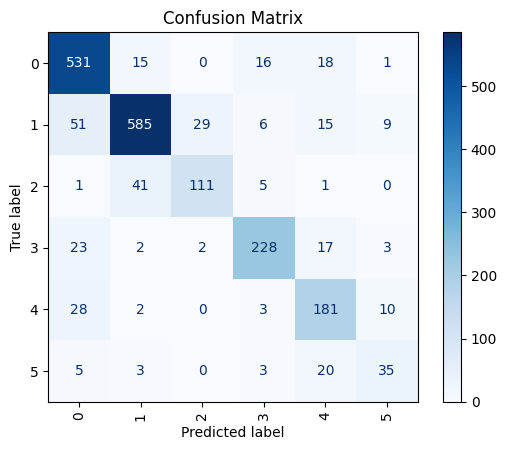

In [18]:
###############################################################################################################
# TODO: Generate predictions for all test samples and analyze the model's overall performance. Display the     #
#       confusion matrix to visualize the differences between true and predicted labels, helping to interpret  #
#       the model's classification results.                                                                   #
###############################################################################################################

# Your code for generating predictions and displaying the confusion matrix goes here
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
padded_test_tensor = padded_test_tensor.to(device)
with torch.no_grad():
    test_outputs = model(padded_test_tensor)
    _, test_predictions = torch.max(test_outputs, 1)
conf_matrix = confusion_matrix(test_label_tensor.cpu().numpy(), test_predictions.cpu().numpy())

classes = sorted(label_counts.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Final Analysis

After visualizing the confusion matrix based on your model’s predictions, analyze the results and provide insights into the model’s classification performance.

### **Question:**
<span style="font-size: 1.2em;">Which class seems to get confused with the class *love* the most?</span>

**Remember the class labels:**
- **0:** *Sadness*
- **1:** *Joy*
- **2:** *Love*
- **3:** *Anger*
- **4:** *Fear*
- **5:** *Surprise*

Reflect on the confusion matrix to answer this question and provide your reasoning for why this confusion might occur based on the emotional nature of the classes.


<font color='green'>From the confusion matrix, it’s clear that the class "Love" (label 2) is most often mistaken for "Joy" (label 1), with 41 instances of misclassification.
This makes sense when you think about the emotional overlap between the two. Both "Love" and "Joy" are positive feelings, and the language used to express them often shares similarities. For example, words like "happiness," "affection," or "care" could easily apply to both emotions, making it hard for the model to distinguish between them. To address this, we might need to enhance the model’s understanding of context or provide more examples that highlight the subtle differences between these emotions.</font>

# **Best regards.**